# Exercise 5, Machine Learning 2022

The following lab-session is adapted from those of Sections 5.3 and 6.3 in Introduction to Statistical Learning with R.

### The Auto dataset
We use the `Auto` dataset that was used as an example throughout Chapter 3 on linear regression. Here, we treat the variable `mpg` (gas miles in miles per gallon) as the response and `horsepower` as the single predictor.

The data has 392 observations on the following 9 variables.

`mpg` miles per gallon

`cylinders` Number of cylinders between 4 and 8 displacementEngine displacement (cu. inches) 

`horsepower` Engine horsepower

`weight` Vehicle weight (lbs.)

`acceleration` Time to accelerate from 0 to 60 mph (sec.)

`year` Model year (modulo 100)

`origin` Origin of car (1. American, 2. European, 3. Japanese)

`name` Vehicle name

In [124]:
# Import relevant packages
import numpy as np
from pandas import read_csv, DataFrame
from math import log, sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf 
import random
from sklearn.metrics import mean_squared_error

In [125]:
# Load data from csv; change the directory as you need!
Auto = read_csv("./Auto.csv")
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


*It is recommended that you set a random seed, so that any results based on randomness are recreated whenever you run the notebook.*

In [126]:
## Set seed!
def reseed(seed):
    np.random.seed(seed)
    random.seed(seed)
reseed(1337)

## The validation set approach

Split the set of observations into two halves by selecting a random subset of 196 obervations out of the original 392 observations. We refer to these observations as the *training set* and the remaining observations as the *validation set*. For creating the random split, you can use `random.sample(seq, n)` to select `n` numbers without replacement from the sequence `seq`. (There is also a built-in function `train_test_split` that can split your data, but here you split it yourself so that you understand in detail how to achieve the datasets).

In [127]:
def split_data():
    n = len(Auto)
    train_sample = random.sample(range(n), n // 2)
    test_sampel = [i for i in range(n) if i not in train_sample]
    df_train = Auto.loc[train_sample]
    df_test = Auto.loc[test_sampel]
    return df_train, df_test
df_train, df_test = split_data()

Fit a linear regression on the training set: `mpg`$= \beta_0 + \beta_1$ `horsepower` $+\epsilon$.

In [128]:
mod = smf.ols("mpg ~ horsepower", data=df_train)
res = mod.fit()
print(res.summary())
# Horsepower decreases miles per gallon

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     275.1
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           4.73e-39
Time:                        16:55:43   Log-Likelihood:                -577.38
No. Observations:                 196   AIC:                             1159.
Df Residuals:                     194   BIC:                             1165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5269      0.983     39.192      0.0

Compute the MSE on the 196 observations that are the validation set.

In [129]:
Y = df_test['mpg']
Y_hat = res.predict(df_test['horsepower'])
MSE = mean_squared_error(Y, Y_hat)
print(f"MSE: {MSE}")

MSE: 27.228024781418068


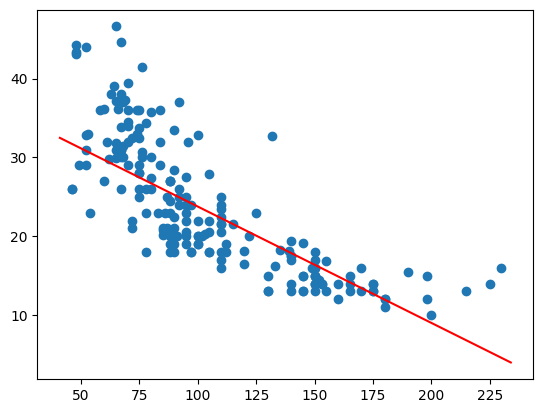

In [130]:
plt.scatter(x=df_test['horsepower'], y=df_test['mpg'])
x = np.arange(df_test['horsepower'].min()-5, df_test['horsepower'].max()+5)
plt.plot(x, res.params.Intercept + res.params.horsepower * x, color='red')
plt.show()

Now estimate also the MSE for the quadradic and cubic regressions.

The ISLwR book found an estimated test MSE of (23.27, 18.27, and 18.79) for the three regression models. 

Set another seed and create a different split of your data - do you get different results? Why?


MSE for linear:  27.228024781418068
MSE for quadratic:  21.634807772766862
MSE for cubic:  22.278396202049972


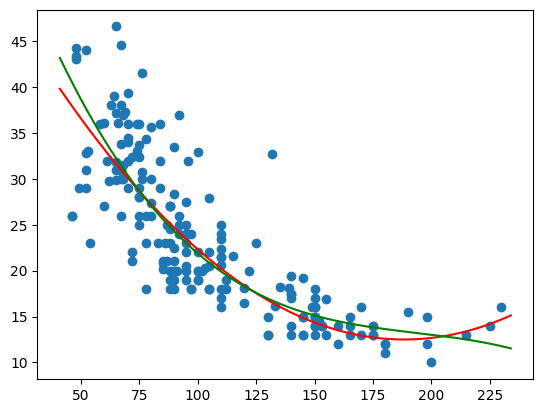

MSE for linear:  27.228024781418068
MSE for quadratic:  21.26426218954818
MSE for cubic:  21.79686773335034


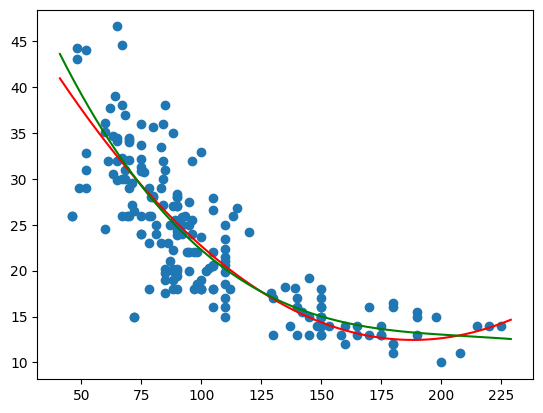

In [131]:
def train_print(df_train, df_test):
    Y = df_test['mpg']

    quad = smf.ols("mpg ~ horsepower + I(horsepower**2)", data=df_train).fit()
    quad_MSE = mean_squared_error(Y, quad.predict(df_test['horsepower']))
    cube = smf.ols("mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)", data=df_train).fit()
    cube_MSE = mean_squared_error(Y, cube.predict(df_test['horsepower']))

    print("MSE for linear: ", MSE)
    print("MSE for quadratic: ", quad_MSE)
    print("MSE for cubic: ", cube_MSE)
    plt.scatter(x=df_test['horsepower'], y=df_test['mpg'])
    x = np.arange(df_test['horsepower'].min()-5, df_test['horsepower'].max()+5)
    plt.plot(x, quad.params.Intercept + quad.params.horsepower * x + quad.params['I(horsepower ** 2)']*x**2, color='red')
    plt.plot(x, cube.params.Intercept + cube.params.horsepower * x + cube.params['I(horsepower ** 2)']*x**2 + cube.params['I(horsepower ** 3)']*x**3, color='green')
    plt.show()

train_print(df_train, df_test)
reseed(8080)
df_train, df_test = split_data()
train_print(df_train, df_test)

Which model would you choose based on the estimated MSE? 

If you instead train the models on the entire data and perform model selection via F-tests or AIC, would you choose differently?

In [132]:
# Quadratic has the best fit
def train_models(data):
    models = []
    for i in [0, 2, 3]:
        models.append(smf.ols("mpg ~ horsepower" + "+ I(horsepower**{})".format(i), data=data).fit())
    return models

models = train_models(Auto)
aic = models[0].aic
# Calculate AIC for each model
AICs = [model.aic for model in models]
best_model = AICs.index(min(AICs))
print(best_model)
# The best model is the quadratic one.

1


## Leave-one-out cross-validation

Implement leave-one-out cross-validation and use it to estimate the MSE for the three regression models above.

In [133]:
def LOOCV(data: DataFrame, x_transformation):
    n = len(data)
    mses = []
    for i in range(n):
        validation = data.loc[i]
        training = data.drop(i)

        y_train = training['mpg']
        x_train = sm.add_constant(x_transformation(training['horsepower']))
        y_test = validation['mpg']
        x_test = np.c_[1, x_transformation(validation['horsepower'])]

        sm1 = sm.OLS(y_train, x_train).fit()
        mse = mean_squared_error([y_test], sm1.predict(x_test))
        mses.append(mse)
    
    mse = np.mean(mse)
    return mse

print(f"LOOCV MSE for linear: {LOOCV(Auto, lambda x: np.c_[x])}")
print(f"LOOCV MSE for quadratic: {LOOCV(Auto, lambda x: np.c_[x, x**2])}")
print(f"LOOCV MSE for cubic: {LOOCV(Auto, lambda x: np.c_[x, x**2, x**3])}")

LOOCV MSE for linear: 16.169806409688476
LOOCV MSE for quadratic: 16.542522587070927
LOOCV MSE for cubic: 17.496777814431596


## k-fold cross-validation

Estimate the MSE now from k-fold cross-validation that you implement yourself. If you set k=10, then you get Figure 5.6 from the book, but you are welcome to choose another k. Make sure that you properly randomise observations into the k folds! One way is to first make a random permutation of row indices and then chop the re-ordered dataset into k (roughly) even parts.

The LOOCV estimate of the MSE can also be computed automatially with sklearn. In fact, sklearn provides a lot of functionality for cross-validation. However, our objective right now is to understand how the algorithms work, so that you learn to reflect on them and use the automatic functionality appropriately.

In [134]:
def kfold(model: str, y: str, data: DataFrame, k=5):
    n = len(data)
    splits = []
    test_len = n // k
    samples = list(range(n))
    for _ in range(k-1):
        test_sample = random.sample(samples, test_len)
        splits.append(test_sample)
        samples = [i for i in samples if i not in test_sample]
    splits.append(samples)

    mses = []
    for test_sample in splits:
        test_data = data.loc[test_sample]
        train_data = data.drop(test_sample)

        mod = smf.ols(model, data=train_data).fit()
        pred = mod.predict(test_data)
        mse = mean_squared_error(test_data[y], pred)
        mses.append(mse)
    mse = np.mean(mses)
    return(mse)

print(f"MSE linear: {kfold('mpg ~ horsepower', 'mpg', Auto)}")
print(f"MSE quad: {kfold('mpg ~ horsepower + I(horsepower**2)', 'mpg', Auto)}")
print(f"MSE cube: {kfold('mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)', 'mpg', Auto)}")

MSE linear: 24.231327241947657
MSE quad: 19.135219328599028
MSE cube: 19.13003944275757


Extend your code with a for-loop that iterates over increasing orders of the polynomial (1 to 10). Note that is possible to autogenerate a design matrix with all the terms of the polynomial with functions such as `sklearn.preprocessing.PolynomialFeatures` (It should also work for several features; a degree 2 polynomial in features x1 and x2 would need  $1+x_1+x_2+x_1x_2+x_1^2+x_2^2$, i.e. also the term $x_1x_2$.)

In [138]:
mses = []
for i in range(10):
    extra = f"I(horsepower**{i})"
    mse = kfold('mpg ~ horsepower + ' + extra, 'mpg', Auto)
    mses.append(mse)
    print(f"Order {i+1} MLE: {mse}")

Order 1 MLE: 24.18698830749903
Order 2 MLE: 24.168483416164445
Order 3 MLE: 19.399641255273757
Order 4 MLE: 19.555824373106553
Order 5 MLE: 19.92260230002627
Order 6 MLE: 19.989802205512213
Order 7 MLE: 20.65778713850164
Order 8 MLE: 166.36903994280004
Order 9 MLE: 597.816253516137
Order 10 MLE: 594.4454914655255


Plot the resulting MSE curve against the degree of the polynomial (this is the complexity or the flexibility). 

Do you get the same conclusion as before regarding your choice of model?

Was it faster than LOOCV?

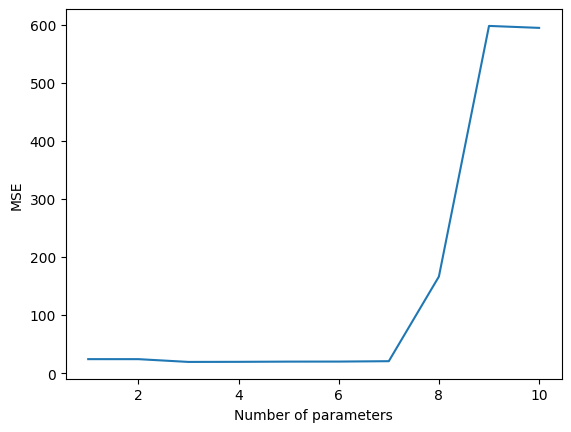

In [141]:
plt.plot(range(1, len(mses)+1), mses)
plt.ylabel("MSE")
plt.xlabel("Number of parameters")
plt.show()

## Shrinkage/Regularization

Now try the two shrinkage methods we saw on Friday, ridge regression and lasso. To make things a bit more exciting, include in your models all variables available in the dataset, and perhaps a few polynomial terms for `horsepower` now that you know they are relevant. The `name` variable is evidently an identifyer and should not be used as a predictor in the model.

The Lasso estimates for coefficients $\beta$ in a linear regression model are found by minimising $RSS + \lambda\sum_{j=1}^p|\beta_j|$ rather than RSS. 

In Ridge regression, we estimate $\beta$ by minimising $RSS + \lambda\sum_{j=1}^p\beta_j^2$ rather than RSS. 

In both cases, we need to set the regularation parameter $\lambda$. **The parameter $\lambda$ is called `alpha` in the Python implementations**


The relevant method in the statsmodel library is `fit_regularized`, which you use in place of `fit` after instantiating an ols model. If `L1_wt=1`, the fit is the lasso (L1-penalty). Ridge regression (L2-penalty) is obtained by setting `L1_wt=0`.  The reason we need to set parameter `L1_wt` is that the method actually implements the more general 'elastic net' penalty, which is a convex combination of the Lasso penalty and the ridge regression penalty with weight `L1_wt`. The fitting method returns a `RegressionResults` object, from which you can extract `params` and `fittedvalues`, and it has a `predict` method just like the usual linear regression output from ols.

The sklearn libary has methods `Ridge` and `Lasso`. 

**Set aside a test set of about 25% of the data that you can use at the end to estimate the MSE of your final model. Use the remaining data to train the regularised regression models.**

### Ridge regression

First, carry out a ridge regression where the regulation parameter $\lambda$ is fixed at 10. 

In fact, $\lambda = 10$ is a rather arbitrary suggestion. We need to decide on a suitable value for the hyperparameter $\lambda$. This we can do using a dedicated validation set, or we could do it by cross-validation. We do the latter.

Take a suitable range of $\lambda \in [0, \infty)$, for instance you can take a sequence $10^i, i=-2, \ldots, 5$. Using 5-fold cross-validation to estimate the MSE (call it `MSE_lambda`) for each $\lambda$, make a plot of how MSE changes with $\lambda$. Based on this plot, how would you choose $\lambda$? 

Having chosen a $\lambda$, would it be appropriate to report the corresponding `MSE_lambda` as the test error for the ridge regression?
Compute the test MSE using the dedicated test set and compare to `MSE_lambda`.

In fact, once we have chosen the regularisation parameter $\lambda$, we should preferably make use of *all of the data* to (re-)train the model, and then report the associated test MSE from the test data. Do this, and inspect the model estimates.

### Lasso

Following the same procedure as for ridge regression, train a lasso regression where the regularisation parameter $\lambda$ is selected by cross-validation. 

Compare the estimated coefficients for your lasso to those from the ridge regression -- did lasso result in a more sparse model? (i.e. did it set some coefficients to zero and thus eliminate features from the model)